In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

In [5]:
import torch

In [3]:
model = AutoModelForImageClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_eye_model")
processor = AutoImageProcessor.from_pretrained("/content/drive/MyDrive/fine_tuned_eye_model")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Dataset

In [28]:
import pandas as pd
from PIL import Image
import torch
import ast
from torch.utils.data import Dataset, DataLoader
import os


df_raw = pd.read_csv("/content/drive/MyDrive/test_data.csv")

df = pd.DataFrame()
df["path"] = df_raw["path"].apply(lambda x: ast.literal_eval(x)[0])
df["label"] = df_raw["label"]

base_path = "/content/drive/MyDrive/eye_test_images/test"

df["path"] = df["path"].apply(lambda p: p.replace("eye_test_images/test", base_path))


df.head()

,path,label
0,/content/drive/MyDrive/eye_test_images/test/ca...,0
1,/content/drive/MyDrive/eye_test_images/test/ca...,0
2,/content/drive/MyDrive/eye_test_images/test/ca...,0
3,/content/drive/MyDrive/eye_test_images/test/ca...,0
4,/content/drive/MyDrive/eye_test_images/test/ca...,0


In [30]:
for img, label in test_loader:
    print("Imagen batch:", img.shape)
    print("Labels:", label)
    break


Imagen batch: torch.Size([16, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [31]:
import os
print("Primer archivo:", df["path"].iloc[0])
print("¿Existe?:", os.path.exists(df["path"].iloc[0]))


Primer archivo: /content/drive/MyDrive/eye_test_images/test/cataract/1164_left.jpg
¿Existe?: True


In [32]:
class FixedTestDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row["path"]).convert("RGB")
        label = row["label"]
        inputs = self.processor(images=image, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0), torch.tensor(label)

test_dataset = FixedTestDataset(df, processor)
test_loader = DataLoader(test_dataset, batch_size=16)

# Prediction

In [34]:
import torch

def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=images)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds, labels = predict(model, test_loader, device)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_metrics(preds, labels, id2label):
    label_names = list(id2label.values())

    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(labels, preds, target_names=label_names))

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Precision: 0.9306
Recall:    0.9297
F1-score:  0.9296

Classification Report:

                     precision    recall  f1-score   support

           Cataract       0.93      0.94      0.94       105
DiabeticRetinopathy       0.99      1.00      1.00       111
           Glaucoma       0.86      0.91      0.89       102
             Normal       0.93      0.86      0.90       109

           accuracy                           0.93       427
          macro avg       0.93      0.93      0.93       427
       weighted avg       0.93      0.93      0.93       427



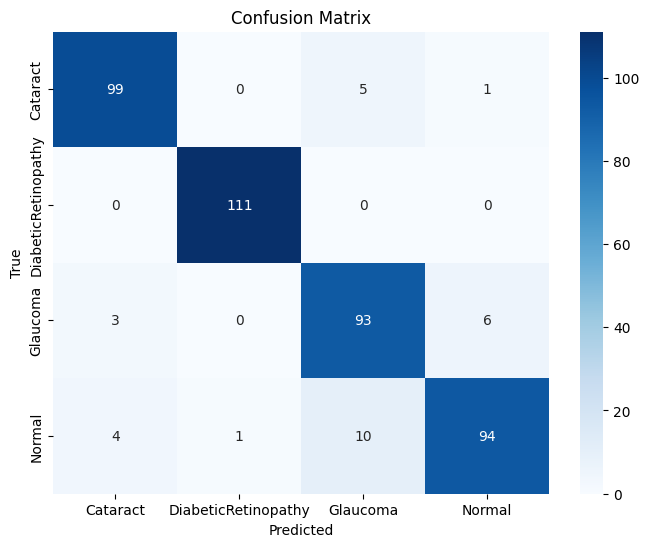

In [37]:
evaluate_metrics(preds, labels, model.config.id2label)

# LIME

In [38]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d172910a0b1f0ee7e11158070aff106441f520cea98496d9baad9d5f3c051e28
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [39]:
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image

def apply_lime(model, df, processor, device, num_samples=5, random_seed=42):
    explainer = lime_image.LimeImageExplainer()
    np.random.seed(random_seed)

    indices = range(len(df)) if num_samples is None else np.random.choice(len(df), num_samples, replace=False)

    for idx in indices:
        img_path = df.iloc[idx]["path"]
        label = df.iloc[idx]["label"]
        image = Image.open(img_path).convert("RGB")
        np_image = np.array(image)

        def predict_fn(images_np_batch):
            batch = [processor(Image.fromarray(img).convert("RGB"), return_tensors="pt")["pixel_values"].squeeze(0) for img in images_np_batch]
            batch_tensor = torch.stack(batch).to(device)
            with torch.no_grad():
                outputs = model(pixel_values=batch_tensor)
                return torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

        explanation = explainer.explain_instance(
            np_image,
            predict_fn,
            top_labels=1,
            hide_color=0,
            num_samples=1000
        )

        temp, mask = explanation.get_image_and_mask(
            label=explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )
        plt.figure()
        plt.title(f"True: {model.config.id2label[label]}, Predicted: {model.config.id2label[explanation.top_labels[0]]}")
        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.axis("off")
        plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

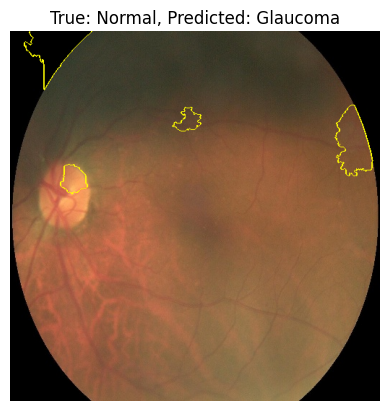

  0%|          | 0/1000 [00:00<?, ?it/s]

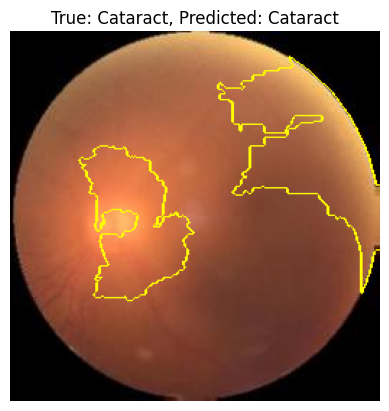

  0%|          | 0/1000 [00:00<?, ?it/s]

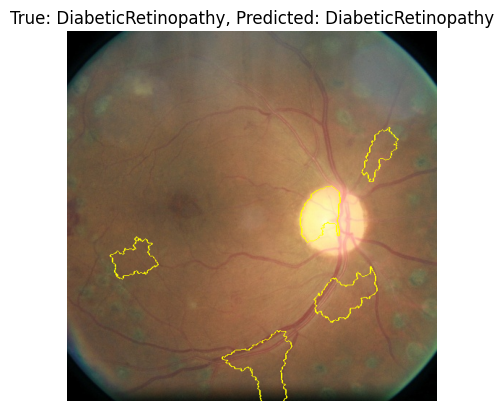

  0%|          | 0/1000 [00:00<?, ?it/s]

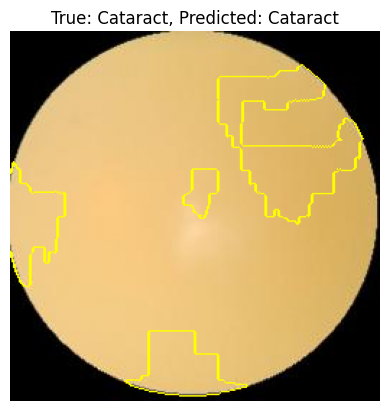

  0%|          | 0/1000 [00:00<?, ?it/s]

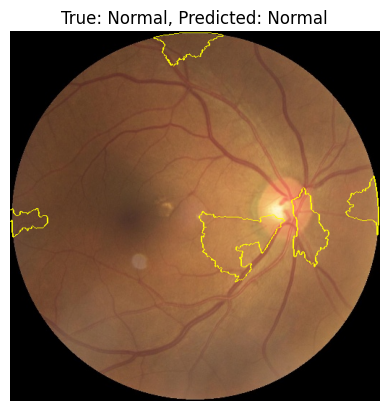

  0%|          | 0/1000 [00:00<?, ?it/s]

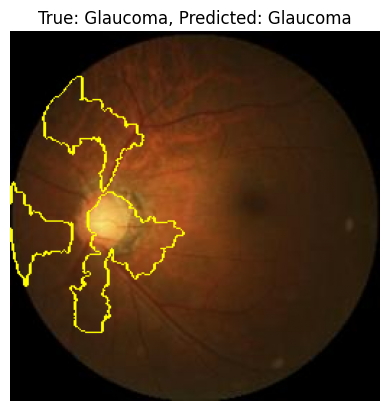

In [41]:
apply_lime(model, df, processor, device, num_samples=6)